In [1]:
import pandas as pd
import numpy as np
import os

from bqplot import (
    LogScale, LinearScale, OrdinalColorScale, ColorAxis,
    Axis, Scatter, Lines, CATEGORY10, Label, Figure, Tooltip
)

from ipywidgets import HBox, VBox, IntSlider, Play, jslink

In [20]:
df = pd.read_csv('animal.csv')
df['count'] = 1
df = pd.DataFrame(df.groupby(['Intake Date'])['count'].sum())

In [21]:
df.index = pd.to_datetime(df.index)

In [22]:
df.head()

,count
Intake Date,
2011-01-01,68
2012-01-01,83
2013-01-01,95
2011-01-02,84
2012-01-02,89


In [30]:
df = df.sort_values('Intake Date')
df.head()

,count
Intake Date,
2011-01-01,68
2011-01-02,84
2011-01-03,120
2011-01-04,213
2011-01-05,239


In [39]:
len(df['count'])

1096

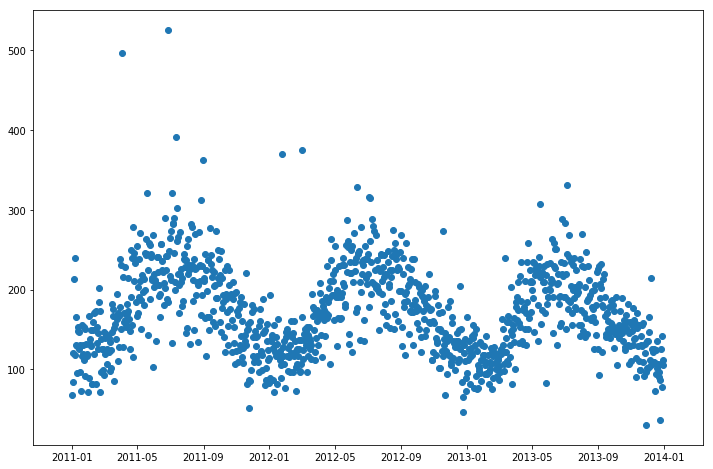

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(df.index, df['count'])
plt.show()

In [43]:
initial_year = 1800

In [44]:
data = pd.read_json(os.path.abspath('nations.json'))

In [45]:
def clean_data(data):
    for column in ['income', 'lifeExpectancy', 'population']:
        data = data.drop(data[data[column].apply(len) <= 4].index)
    return data

def extrap_interp(data):
    data = np.array(data)
    x_range = np.arange(1800, 2009, 1.)
    y_range = np.interp(x_range, data[:, 0], data[:, 1])
    return y_range

def extrap_data(data):
    for column in ['income', 'lifeExpectancy', 'population']:
        data[column] = data[column].apply(extrap_interp)
    return data

In [46]:
data = clean_data(data)
data = extrap_data(data)

In [47]:
income_min, income_max = np.min(data['income'].apply(np.min)), np.max(data['income'].apply(np.max))
life_exp_min, life_exp_max = np.min(data['lifeExpectancy'].apply(np.min)), np.max(data['lifeExpectancy'].apply(np.max))
pop_min, pop_max = np.min(data['population'].apply(np.min)), np.max(data['population'].apply(np.max))

In [48]:
def get_data(year):
    year_index = year - 1800
    income = data['income'].apply(lambda x: x[year_index])
    life_exp = data['lifeExpectancy'].apply(lambda x: x[year_index])
    pop =  data['population'].apply(lambda x: x[year_index])
    return income, life_exp, pop

In [49]:
tt = Tooltip(fields=['name', 'x', 'y'], labels=['Country Name', 'Income per Capita', 'Life Expectancy'])

In [50]:
year_label = Label(x=[0.75], y=[0.10], default_size=46, font_weight='bolder', colors=['orange'],
                   text=[str(initial_year)], enable_move=True)

In [51]:
x_sc = LogScale(min=income_min, max=income_max)
y_sc = LinearScale(min=life_exp_min, max=life_exp_max)
c_sc = OrdinalColorScale(domain=data['region'].unique().tolist(), colors=CATEGORY10[:6])
size_sc = LinearScale(min=pop_min, max=pop_max)

In [52]:
ax_y = Axis(label='Life Expectancy', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')
ax_x = Axis(label='Income per Capita', scale=x_sc, grid_lines='solid')

In [53]:
cap_income, life_exp, pop = get_data(initial_year)

In [54]:
wealth_scat = Scatter(x=cap_income, y=life_exp, color=data['region'], size=pop,
                      names=data['name'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc, 'color': c_sc, 'size': size_sc},
                      default_size=4112, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

In [55]:
nation_line = Lines(x=data['income'][0], y=data['lifeExpectancy'][0], colors=['Gray'],
                       scales={'x': x_sc, 'y': y_sc}, visible=False)

In [56]:
time_interval = 10

In [57]:
fig = Figure(marks=[wealth_scat, year_label, nation_line], axes=[ax_x, ax_y],
             title='Health and Wealth of Nations', animation_duration=time_interval, figsize=(12,12))


In [58]:
year_slider = IntSlider(min=1800, max=2008, step=1, description='Year', value=initial_year)

In [59]:
def hover_changed(change):
    if change.new is not None:
        nation_line.x = data[data['name'] == wealth_scat.names[change.new]]['income'].values[0]
        nation_line.y = data[data['name'] == wealth_scat.names[change.new]]['lifeExpectancy'].values[0]
        nation_line.visible = True
    else:
        nation_line.visible = False
        
wealth_scat.observe(hover_changed, 'hovered_point')

In [60]:
def year_changed(change):
    wealth_scat.x, wealth_scat.y, wealth_scat.size = get_data(year_slider.value)
    year_label.text = [str(year_slider.value)]

year_slider.observe(year_changed, 'value')

In [61]:
play_button = Play(min=1800, max=2008, interval=time_interval)
jslink((play_button, 'value'), (year_slider, 'value'))

In [62]:
VBox([HBox([play_button, year_slider]), fig])